In [1]:
%matplotlib widget

In [85]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import numpy as np
import os
from stompy.plot import plot_wkb
from stompy import memoize, utils
from shapely import geometry
from shapely.ops import nearest_points
from matplotlib import collections
from stompy.plot import stream_quiver

In [51]:
from stompy.grid import multi_ugrid
import six
six.moves.reload_module(multi_ugrid)
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/richmondvol1/rusty/stompy/stompy/model/delft/dflow_model.py'>

In [52]:
# Find a reasonably long run (month+?)
# This is only daily map output
# dfm_base_run_dir="dfm_spinup"

# longer hourly output - but takes forever to load.
dfm_base_run_dir="/fortcollinsvol2/hpcshared/open_bay/hydro/full_res/wy2017-v24-hf/runs/wy2017-v24-hf"

# dfm_base_run_dir = "bloom_tracers_v15/run_20220804T1820_20220830T0000_v00"

In [53]:
model = dfm.DFlowModel.load(dfm_base_run_dir)

In [54]:
map_ds = model.map_dataset()

grid = map_ds.grid
shore_poly = grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3345371672.523513, 15 potential interiors


In [55]:
# Get the Godin window
x_in = (np.arange(101)==50).astype(float)
from stompy import filters

impulse_resp = filters.lowpass_godin(x_in,mean_dt_h=1.0)
godin_window = impulse_resp[impulse_resp>0.0]
godin_offset=len(godin_window)//2 # truncate is probably correct

In [100]:
# Extract instantaneous velocities, but also subtidal velocities.
# All from depth-averaged velocity field.
# Does this run have evenly spaced layers?

dsigma = np.diff(map_ds.dss[0].LayCoord_w.values)

@memoize.memoize(lru=100)
def get_davg_data(tidx):
    u = map_ds.ucx.isel(time=tidx)
    v = map_ds.ucy.isel(time=tidx)
    return dict(time=map_ds.time.isel(time=tidx),
                u_davg=(u.values * dsigma[None,:]).sum(axis=1),
                v_davg=(v.values * dsigma[None,:]).sum(axis=1),
                sa1=map_ds.sa1.isel(time=tidx,laydim=-1).values,
                waterdepth=map_ds.waterdepth.isel(time=tidx).values)

In [104]:
def get_data(tidx):
    tidx_low = int(np.floor(tidx))
    tidx_high= int(np.ceil(tidx))
    data_low = dict(get_davg_data(tidx_low))
    if tidx_low==tidx_high:
        return data_low
    else:
        data_high = dict(get_davg_data(tidx_high))
        alpha=(tidx-tidx_low)/(tidx_high-tidx_low)
        data_interp = {k:(data_low[k] + alpha*(data_high[k]-data_low[k])) 
                       for k in data_low }
        return data_interp
#data = get_data(tidx=300.5)

In [105]:
@memoize.memoize(lru=10)
def cart_samples(zoom,dx):
    x=np.arange(zoom[0], zoom[1], dx)
    y=np.arange(zoom[2], zoom[3], dx)
    X,Y=np.meshgrid(x,y)
    xy=np.c_[X.ravel(), Y.ravel()]
    def neg(i): return i if i is not None else -1
    cells=np.array([neg(grid.select_cells_nearest(p,inside=True)) for p in utils.progress(xy)])
    
    valid=cells>=0
    samples = np.zeros( valid.sum(), dtype=[('x',float,2),('c',int)])
    samples['x']=xy[valid]
    samples['c']=cells[valid]
    return samples

In [106]:
six.moves.reload_module(stream_quiver)

<module 'stompy.plot.stream_quiver' from '/richmondvol1/rusty/stompy/stompy/plot/stream_quiver.py'>

In [107]:
_quiv=None

@memoize.memoize(lru=5)
def get_quiver(data,zoom):
    global _quiv
    U=np.c_[data['u_davg'],data['v_davg']]
    if _quiv is None:
        _quiv = stream_quiver.RegularStreamlineQuiver(grid,
                                                      U=U,
                                                      max_t=5000.0,max_dist=10000,
                                                      dt=60.0,
                                                      clip=zoom,
                                                      dx=1200)
    else:
        _quiv.update_U(U)
    return _quiv

In [108]:
import stompy.plot.cmap as scmap
from matplotlib import cm
desat=0.3
salt_cmap = scmap.transform_color(lambda rgb: desat+(1.0-desat)*rgb, cm.turbo)

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3345371672.523513, 15 potential interiors
INFO:utils:206/806
INFO:utils:416/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 00:00Z


INFO:utils:208/806
INFO:utils:415/806
INFO:utils:611/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 00:30Z


INFO:utils:205/806
INFO:utils:408/806
INFO:utils:608/806


Plotting  2016-10-01 01:00Z


INFO:utils:205/806
INFO:utils:410/806
INFO:utils:620/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 01:30Z


INFO:utils:198/806
INFO:utils:390/806
INFO:utils:589/806
INFO:utils:792/806


Plotting  2016-10-01 02:00Z


INFO:utils:208/806
INFO:utils:418/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 02:30Z


INFO:utils:210/806
INFO:utils:416/806
INFO:utils:624/806


Plotting  2016-10-01 03:00Z


INFO:utils:211/806
INFO:utils:420/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 03:30Z


INFO:utils:206/806
INFO:utils:414/806
INFO:utils:620/806


Plotting  2016-10-01 04:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 04:30Z


INFO:utils:204/806
INFO:utils:408/806
INFO:utils:610/806


Plotting  2016-10-01 05:00Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:618/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 05:30Z


INFO:utils:207/806
INFO:utils:415/806
INFO:utils:620/806


Plotting  2016-10-01 06:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 06:30Z


INFO:utils:210/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-01 07:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:634/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 07:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:636/806


Plotting  2016-10-01 08:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 08:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:626/806


Plotting  2016-10-01 09:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 09:30Z


INFO:utils:199/806
INFO:utils:397/806
INFO:utils:593/806
INFO:utils:788/806


Plotting  2016-10-01 10:00Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:619/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 10:30Z


INFO:utils:206/806
INFO:utils:413/806
INFO:utils:618/806


Plotting  2016-10-01 11:00Z


INFO:utils:207/806
INFO:utils:415/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 11:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806


Plotting  2016-10-01 12:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 12:30Z


INFO:utils:207/806
INFO:utils:418/806
INFO:utils:628/806


Plotting  2016-10-01 13:00Z


INFO:utils:208/806
INFO:utils:420/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 13:30Z


INFO:utils:201/806
INFO:utils:413/806
INFO:utils:625/806


Plotting  2016-10-01 14:00Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 14:30Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:623/806


Plotting  2016-10-01 15:00Z


INFO:utils:210/806
INFO:utils:418/806
INFO:utils:624/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 15:30Z


INFO:utils:206/806
INFO:utils:414/806
INFO:utils:620/806


Plotting  2016-10-01 16:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:623/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 16:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:621/806


Plotting  2016-10-01 17:00Z


INFO:utils:208/806
INFO:utils:414/806
INFO:utils:620/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 17:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806


Plotting  2016-10-01 18:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 18:30Z


INFO:utils:201/806
INFO:utils:402/806
INFO:utils:606/806


Plotting  2016-10-01 19:00Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 19:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-01 20:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 20:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-01 21:00Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 21:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806


Plotting  2016-10-01 22:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 22:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806


Plotting  2016-10-01 23:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-01 23:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806


Plotting  2016-10-02 00:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 00:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-02 01:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 01:30Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:632/806


Plotting  2016-10-02 02:00Z


INFO:utils:204/806
INFO:utils:416/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 02:30Z


INFO:utils:209/806
INFO:utils:416/806
INFO:utils:626/806


Plotting  2016-10-02 03:00Z


INFO:utils:212/806
INFO:utils:422/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 03:30Z


INFO:utils:208/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-02 04:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:623/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 04:30Z


INFO:utils:205/806
INFO:utils:409/806
INFO:utils:611/806


Plotting  2016-10-02 05:00Z


INFO:utils:198/806
INFO:utils:400/806
INFO:utils:601/806
INFO:utils:800/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 05:30Z


INFO:utils:207/806
INFO:utils:413/806
INFO:utils:616/806


Plotting  2016-10-02 06:00Z


INFO:utils:206/806
INFO:utils:411/806
INFO:utils:616/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 06:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806


Plotting  2016-10-02 07:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 07:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:630/806


Plotting  2016-10-02 08:00Z


INFO:utils:212/806
INFO:utils:403/806
INFO:utils:577/806
INFO:utils:764/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 08:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:634/806


Plotting  2016-10-02 09:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:638/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 09:30Z


INFO:utils:206/806
INFO:utils:412/806
INFO:utils:616/806


Plotting  2016-10-02 10:00Z


INFO:utils:205/806
INFO:utils:410/806
INFO:utils:613/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 10:30Z


INFO:utils:205/806
INFO:utils:410/806
INFO:utils:613/806


Plotting  2016-10-02 11:00Z


INFO:utils:205/806
INFO:utils:408/806
INFO:utils:613/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 11:30Z


INFO:utils:206/806
INFO:utils:412/806
INFO:utils:617/806


Plotting  2016-10-02 12:00Z


INFO:utils:207/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 12:30Z


INFO:utils:207/806
INFO:utils:415/806
INFO:utils:622/806


Plotting  2016-10-02 13:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 13:30Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806


Plotting  2016-10-02 14:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 14:30Z


INFO:utils:206/806
INFO:utils:412/806
INFO:utils:617/806


Plotting  2016-10-02 15:00Z


INFO:utils:207/806
INFO:utils:413/806
INFO:utils:619/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 15:30Z


INFO:utils:199/806
INFO:utils:404/806
INFO:utils:610/806


Plotting  2016-10-02 16:00Z


INFO:utils:210/806
INFO:utils:418/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 16:30Z


INFO:utils:210/806
INFO:utils:418/806
INFO:utils:619/806


Plotting  2016-10-02 17:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 17:30Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:628/806


Plotting  2016-10-02 18:00Z


INFO:utils:202/806
INFO:utils:407/806
INFO:utils:614/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 18:30Z


INFO:utils:210/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-02 19:00Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:620/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 19:30Z


INFO:utils:209/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-02 20:00Z


INFO:utils:209/806
INFO:utils:420/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 20:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:628/806


Plotting  2016-10-02 21:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-02 21:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-02 22:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:197/806
INFO:utils:398/806
INFO:utils:594/806
INFO:utils:794/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 00:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806


Plotting  2016-10-03 01:00Z


INFO:utils:208/806
INFO:utils:399/806
INFO:utils:594/806
INFO:utils:791/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 01:30Z


INFO:utils:208/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-03 02:00Z


INFO:utils:209/806
INFO:utils:420/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 02:30Z


INFO:utils:205/806
INFO:utils:416/806
INFO:utils:627/806


Plotting  2016-10-03 03:00Z


INFO:utils:208/806
INFO:utils:419/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 03:30Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:629/806


Plotting  2016-10-03 04:00Z


INFO:utils:207/806
INFO:utils:417/806
INFO:utils:615/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 04:30Z


INFO:utils:198/806
INFO:utils:404/806
INFO:utils:609/806


Plotting  2016-10-03 05:00Z


INFO:utils:208/806
INFO:utils:414/806
INFO:utils:618/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 05:30Z


INFO:utils:205/806
INFO:utils:413/806
INFO:utils:619/806


Plotting  2016-10-03 06:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:623/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 06:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806


Plotting  2016-10-03 07:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 07:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-03 08:00Z


INFO:utils:212/806
INFO:utils:425/806
INFO:utils:638/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 08:30Z


INFO:utils:214/806
INFO:utils:429/806
INFO:utils:643/806


Plotting  2016-10-03 09:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:639/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 09:30Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:624/806


Plotting  2016-10-03 10:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:624/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 10:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:623/806


Plotting  2016-10-03 11:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:624/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 11:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806


Plotting  2016-10-03 12:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 12:30Z


INFO:utils:203/806
INFO:utils:409/806
INFO:utils:615/806


Plotting  2016-10-03 13:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 13:30Z


INFO:utils:213/806
INFO:utils:425/806
INFO:utils:637/806


Plotting  2016-10-03 14:00Z


INFO:utils:214/806
INFO:utils:428/806
INFO:utils:642/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 14:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-03 15:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 15:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-03 16:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 16:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:627/806


Plotting  2016-10-03 17:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 17:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:627/806


Plotting  2016-10-03 18:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 18:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-03 19:00Z


INFO:utils:207/806
INFO:utils:415/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 19:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-03 20:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 20:30Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:634/806


Plotting  2016-10-03 21:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:634/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 21:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-03 22:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 22:30Z


INFO:utils:206/806
INFO:utils:413/806
INFO:utils:619/806


Plotting  2016-10-03 23:00Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-03 23:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-04 00:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 00:30Z


INFO:utils:206/806
INFO:utils:412/806
INFO:utils:616/806


Plotting  2016-10-04 01:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 01:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-04 02:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 02:30Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:633/806


Plotting  2016-10-04 03:00Z


INFO:utils:203/806
INFO:utils:416/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 03:30Z


INFO:utils:209/806
INFO:utils:421/806
INFO:utils:632/806


Plotting  2016-10-04 04:00Z


INFO:utils:215/806
INFO:utils:429/806
INFO:utils:642/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 04:30Z


INFO:utils:211/806
INFO:utils:424/806
INFO:utils:635/806


Plotting  2016-10-04 05:00Z


INFO:utils:209/806
INFO:utils:410/806
INFO:utils:606/806
INFO:utils:804/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 05:30Z


INFO:utils:206/806
INFO:utils:411/806
INFO:utils:615/806


Plotting  2016-10-04 06:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 06:30Z


INFO:utils:207/806
INFO:utils:416/806
INFO:utils:623/806


Plotting  2016-10-04 07:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 07:30Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:632/806


Plotting  2016-10-04 08:00Z


INFO:utils:203/806
INFO:utils:411/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 08:30Z


INFO:utils:214/806
INFO:utils:429/806
INFO:utils:643/806


Plotting  2016-10-04 09:00Z


INFO:utils:216/806
INFO:utils:432/806
INFO:utils:647/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 09:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-04 10:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 10:30Z


INFO:utils:208/806
INFO:utils:415/806
INFO:utils:622/806


Plotting  2016-10-04 11:00Z


INFO:utils:203/806
INFO:utils:412/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 11:30Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:630/806


Plotting  2016-10-04 12:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 12:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:628/806


Plotting  2016-10-04 13:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 13:30Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:633/806


Plotting  2016-10-04 14:00Z


INFO:utils:212/806
INFO:utils:425/806
INFO:utils:637/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 14:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:628/806


Plotting  2016-10-04 15:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 15:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:630/806


Plotting  2016-10-04 16:00Z


INFO:utils:213/806
INFO:utils:425/806
INFO:utils:637/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 16:30Z


INFO:utils:209/806
INFO:utils:420/806
INFO:utils:630/806


Plotting  2016-10-04 17:00Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 17:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:630/806


Plotting  2016-10-04 18:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 18:30Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:631/806


Plotting  2016-10-04 19:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 19:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:619/806


Plotting  2016-10-04 20:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 20:30Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806


Plotting  2016-10-04 21:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:634/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 21:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806


Plotting  2016-10-04 22:00Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 22:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-04 23:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-04 23:30Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:632/806


Plotting  2016-10-05 00:00Z


INFO:utils:207/806
INFO:utils:415/806
INFO:utils:620/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 00:30Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:619/806


Plotting  2016-10-05 01:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 01:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806


Plotting  2016-10-05 02:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 02:30Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806


Plotting  2016-10-05 03:00Z


INFO:utils:212/806
INFO:utils:425/806
INFO:utils:637/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 03:30Z


INFO:utils:208/806
INFO:utils:420/806
INFO:utils:632/806


Plotting  2016-10-05 04:00Z


INFO:utils:214/806
INFO:utils:428/806
INFO:utils:642/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 04:30Z


INFO:utils:210/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-05 05:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:623/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 05:30Z


INFO:utils:209/806
INFO:utils:416/806
INFO:utils:622/806


Plotting  2016-10-05 06:00Z


INFO:utils:208/806
INFO:utils:415/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 06:30Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:624/806


Plotting  2016-10-05 07:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 07:30Z


INFO:utils:210/806
INFO:utils:398/806
INFO:utils:592/806
INFO:utils:796/806


Plotting  2016-10-05 08:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 08:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-05 09:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 09:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:628/806


Plotting  2016-10-05 10:00Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 10:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:628/806


Plotting  2016-10-05 11:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 11:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-05 12:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 12:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-05 13:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 13:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-05 14:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:638/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 14:30Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:620/806


Plotting  2016-10-05 15:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 15:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-05 16:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 16:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-05 17:00Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 17:30Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:629/806


Plotting  2016-10-05 18:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 18:30Z


INFO:utils:211/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-05 19:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 19:30Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:619/806


Plotting  2016-10-05 20:00Z


INFO:utils:207/806
INFO:utils:415/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 20:30Z


INFO:utils:208/806
INFO:utils:417/806
INFO:utils:625/806


Plotting  2016-10-05 21:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 21:30Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:638/806


Plotting  2016-10-05 22:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 22:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806


Plotting  2016-10-05 23:00Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-05 23:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-06 00:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 00:30Z


INFO:utils:205/806
INFO:utils:410/806
INFO:utils:614/806


Plotting  2016-10-06 01:00Z


INFO:utils:206/806
INFO:utils:412/806
INFO:utils:616/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 01:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:626/806


Plotting  2016-10-06 02:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 02:30Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806


Plotting  2016-10-06 03:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 03:30Z


INFO:utils:212/806
INFO:utils:413/806
INFO:utils:617/806


Plotting  2016-10-06 04:00Z


INFO:utils:207/806
INFO:utils:418/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 04:30Z


INFO:utils:207/806
INFO:utils:419/806
INFO:utils:631/806


Plotting  2016-10-06 05:00Z


INFO:utils:206/806
INFO:utils:412/806
INFO:utils:617/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 05:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-06 06:00Z


INFO:utils:202/806
INFO:utils:389/806
INFO:utils:581/806
INFO:utils:786/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 06:30Z


INFO:utils:207/806
INFO:utils:416/806
INFO:utils:623/806


Plotting  2016-10-06 07:00Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 07:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-06 08:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 08:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:622/806


Plotting  2016-10-06 09:00Z


INFO:utils:205/806
INFO:utils:413/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 09:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806


Plotting  2016-10-06 10:00Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 10:30Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806


Plotting  2016-10-06 11:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 11:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:630/806


Plotting  2016-10-06 12:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 12:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-06 13:00Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 13:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-06 14:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 14:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:630/806


Plotting  2016-10-06 15:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 15:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-06 16:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:636/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 16:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-06 17:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 17:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806


Plotting  2016-10-06 18:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:634/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 18:30Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-06 19:00Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 19:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806


Plotting  2016-10-06 20:00Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 20:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-06 21:00Z


INFO:utils:210/806
INFO:utils:395/806
INFO:utils:587/806
INFO:utils:787/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 21:30Z


INFO:utils:207/806
INFO:utils:416/806
INFO:utils:625/806


Plotting  2016-10-06 22:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 22:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-06 23:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-06 23:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-07 00:00Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 00:30Z


INFO:utils:205/806
INFO:utils:410/806
INFO:utils:613/806


Plotting  2016-10-07 01:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:622/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 01:30Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:623/806


Plotting  2016-10-07 02:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 02:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-07 03:00Z


INFO:utils:191/806
INFO:utils:382/806
INFO:utils:583/806
INFO:utils:784/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 03:30Z


INFO:utils:208/806
INFO:utils:417/806
INFO:utils:626/806


Plotting  2016-10-07 04:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 04:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-07 05:00Z


INFO:utils:201/806
INFO:utils:411/806
INFO:utils:621/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 05:30Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:621/806


Plotting  2016-10-07 06:00Z


INFO:utils:208/806
INFO:utils:418/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 06:30Z


INFO:utils:208/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-07 07:00Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 07:30Z


INFO:utils:206/806
INFO:utils:415/806
INFO:utils:622/806


Plotting  2016-10-07 08:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:624/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 08:30Z


INFO:utils:207/806
INFO:utils:416/806
INFO:utils:623/806


Plotting  2016-10-07 09:00Z


INFO:utils:208/806
INFO:utils:419/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 09:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:634/806


Plotting  2016-10-07 10:00Z


INFO:utils:209/806
INFO:utils:417/806
INFO:utils:625/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 10:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-07 11:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 11:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-07 12:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 12:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:636/806


Plotting  2016-10-07 13:00Z


INFO:utils:211/806
INFO:utils:423/806
INFO:utils:633/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 13:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-07 14:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 14:30Z


INFO:utils:207/806
INFO:utils:414/806
INFO:utils:620/806


Plotting  2016-10-07 15:00Z


INFO:utils:208/806
INFO:utils:416/806
INFO:utils:623/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 15:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-07 16:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 16:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:633/806


Plotting  2016-10-07 17:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:636/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 17:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:636/806


Plotting  2016-10-07 18:00Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:634/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 18:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-07 19:00Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 19:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806


Plotting  2016-10-07 20:00Z


INFO:utils:207/806
INFO:utils:413/806
INFO:utils:618/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 20:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-07 21:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 21:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:631/806


Plotting  2016-10-07 22:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 22:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806


Plotting  2016-10-07 23:00Z


INFO:utils:213/806
INFO:utils:427/806
INFO:utils:641/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-07 23:30Z


INFO:utils:213/806
INFO:utils:427/806
INFO:utils:640/806


Plotting  2016-10-08 00:00Z


INFO:utils:214/806
INFO:utils:428/806
INFO:utils:641/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 00:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:627/806


Plotting  2016-10-08 01:00Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 01:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:625/806


Plotting  2016-10-08 02:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 02:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-08 03:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 03:30Z


INFO:utils:207/806
INFO:utils:417/806
INFO:utils:626/806


Plotting  2016-10-08 04:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 04:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-08 05:00Z


INFO:utils:214/806
INFO:utils:428/806
INFO:utils:640/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 05:30Z


INFO:utils:209/806
INFO:utils:419/806
INFO:utils:629/806


Plotting  2016-10-08 06:00Z


INFO:utils:208/806
INFO:utils:419/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 06:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-08 07:00Z


INFO:utils:206/806
INFO:utils:417/806
INFO:utils:627/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 07:30Z


INFO:utils:208/806
INFO:utils:419/806
INFO:utils:629/806


Plotting  2016-10-08 08:00Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:632/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 08:30Z


INFO:utils:208/806
INFO:utils:419/806
INFO:utils:628/806


Plotting  2016-10-08 09:00Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 09:30Z


INFO:utils:212/806
INFO:utils:423/806
INFO:utils:632/806


Plotting  2016-10-08 10:00Z


INFO:utils:210/806
INFO:utils:419/806
INFO:utils:626/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 10:30Z


INFO:utils:209/806
INFO:utils:418/806
INFO:utils:626/806


Plotting  2016-10-08 11:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 11:30Z


INFO:utils:206/806
INFO:utils:413/806
INFO:utils:619/806


Plotting  2016-10-08 12:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:638/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 12:30Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:639/806


Plotting  2016-10-08 13:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:639/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 13:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:631/806


Plotting  2016-10-08 14:00Z


INFO:utils:213/806
INFO:utils:425/806
INFO:utils:637/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 14:30Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:638/806


Plotting  2016-10-08 15:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 15:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:628/806


Plotting  2016-10-08 16:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 16:30Z


INFO:utils:211/806
INFO:utils:422/806
INFO:utils:632/806


Plotting  2016-10-08 17:00Z


INFO:utils:212/806
INFO:utils:425/806
INFO:utils:637/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 17:30Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:639/806


Plotting  2016-10-08 18:00Z


INFO:utils:213/806
INFO:utils:427/806
INFO:utils:640/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 18:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:636/806


Plotting  2016-10-08 19:00Z


INFO:utils:213/806
INFO:utils:426/806
INFO:utils:638/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 19:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-08 20:00Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 20:30Z


INFO:utils:210/806
INFO:utils:420/806
INFO:utils:629/806


Plotting  2016-10-08 21:00Z


INFO:utils:211/806
INFO:utils:421/806
INFO:utils:630/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 21:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:634/806


Plotting  2016-10-08 22:00Z


INFO:utils:210/806
INFO:utils:421/806
INFO:utils:631/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 22:30Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:634/806


Plotting  2016-10-08 23:00Z


INFO:utils:212/806
INFO:utils:424/806
INFO:utils:635/806
/richmondvol1/rusty/stompy/stompy/utils.py:660: RuntimeWarning: invalid value encountered in divide
  return vecs / mag(vecs)[...,None]


Plotting  2016-10-08 23:30Z


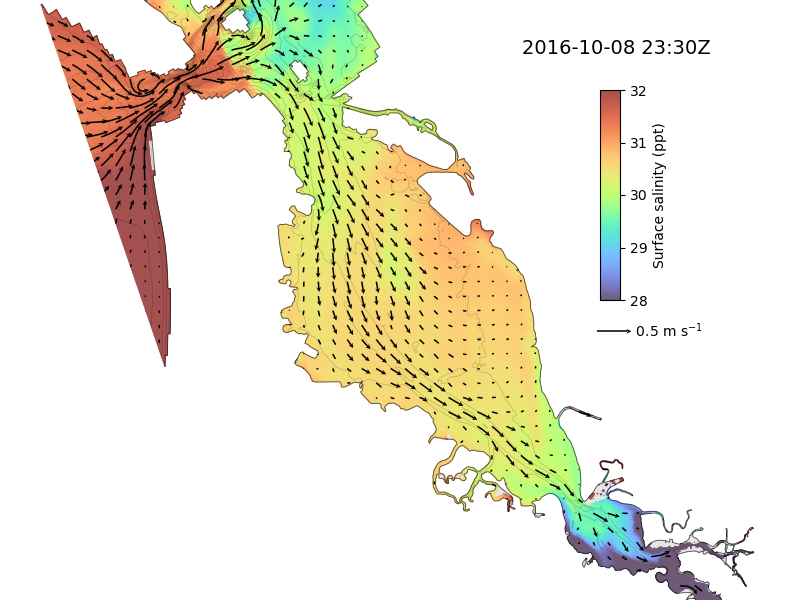

In [110]:
fig = plt.figure(figsize=(8,6))
#zoom=(535921.5766851009, 598522.1874080556, 4142422.35695271, 4192179.7456047614)
zoom=(530484.3434251469, 596827.5282945487, 4142671.14389597, 4192428.5325480215)

dzmin=0.05

def plot_time(tidx):
    fig.clf()
    ax=fig.add_axes([0,0,1,1])
    ax.axis('off')
    
    plot_wkb.plot_wkb(shore_poly,ec='k',alpha=0.6,lw=0.7,fc='none',zorder=2)
    
    ax.axis('equal')
    
    if 1: # Bathy
        if 0:
            grid.contourf_node_values( map_ds.NetNode_z.values, np.linspace(-90,90,33), cmap='GnBu_r', extend='both',zorder=-2)
        if 1:
            # just light contours
            grid.contour_node_values( map_ds.NetNode_z.values, np.linspace(-90,5,15), colors='k',alpha=0.2, 
                                     linestyles='-', linewidths=0.5,zorder=0.5)

    data = get_data(tidx) # handles interpolation for velo, salt, water depth
    
    if 1: # Surface salinity
        scal = data['sa1'] # map_ds.sa1.isel(time=tidx,laydim=-1).values
        wet = (data['waterdepth'] > dzmin)
        
        scal_label="Surface salinity (ppt)"
        #scal = map_ds.sa1.isel(time=tidx,laydim=0).values
        #scal_label="Bottome salinity (ppt)"
        
        salt_coll = grid.plot_cells(values=scal,mask=wet,clim=[28,32],cmap=salt_cmap,ax=ax, lw=0.5, edgecolor='face', zorder=0)
        dry_coll = grid.plot_cells(color='0.9',mask=~wet, lw=0.5, edgecolor='face', zorder=0)
        cax = fig.add_axes([0.75,0.50,0.025,0.35])
        plt.colorbar(salt_coll,cax=cax,label=scal_label)
    
    if 1: # Velocity
        if 1: # Tracked quiver from cartesian
            quiv = get_quiver(data,zoom)
            quiv.size=100
            quiv.coll_args = dict(
                zorder=3,
                color='k',lw=1.1,
                #cmap='inferno_r', clim=[0,0.8], lw=1.4
                )
            quiv.plot_quiver(ax=ax)
            quiv.quiverkey(580000,4.165e6,0.5,"  0.5 m s$^{-1}$",ax=ax)
    
    t=data['time']
    t_str=utils.strftime(t,"%Y-%m-%d %H:%MZ")
    print("Plotting ",t_str)
    ax.text(0.77,0.91,t_str,size=14,transform=ax.transAxes,ha='center')
    
    mask = geometry.Polygon( [[482000,4.13e6],
                              [546500,4.13e6],
                              [544500,4.1609e6],
                              [532000,4.1974e6],
                              [506400,4.2203e6],
                              [479400,4.2203e6]])
    plot_wkb.plot_wkb(mask,ax=ax,fc='w',lw=0.0,ec='none',zorder=4)
    
    ax.axis(zoom)


tidxs=np.arange(1464,1464+8*24,0.5)
fig_dir="vel_salt_frames_v00"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
for frame,tidx in enumerate(tidxs):
    plot_time(tidx)
    fig.savefig(os.path.join(fig_dir,f"frame_{frame:04d}.png"))

In [112]:
from stompy.plot import mkanim

movie_fn=os.path.join(fig_dir,"southbay_vel_salt.mp4")
mkanim.mkanim(movie_fn, os.path.join(fig_dir,"frame_%04d.png"), fps=10)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [116]:
from IPython.display import Video

Video(movie_fn)